In [11]:
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import torchvision
import os

ds = load_dataset("naufalso/stanford_cars")

train_dataset = ds['train']

test_val_split = ds['test'].train_test_split(test_size=0.5, seed=42)
test_dataset = test_val_split['train']
val_dataset = test_val_split['test']

# Print the sizes of the splits
print("Train size:", len(train_dataset))     
print("Test size:", len(test_dataset))        
print("Validation size:", len(val_dataset)) 


Train size: 8103
Test size: 4000
Validation size: 4000


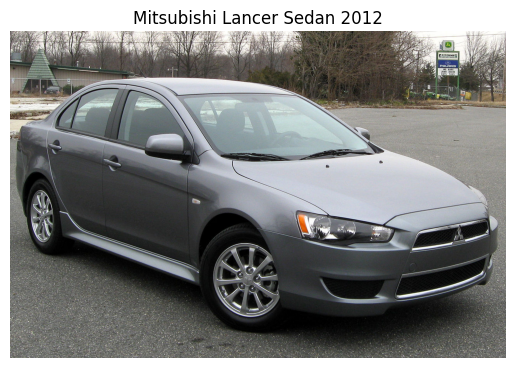

In [12]:
item = train_dataset[8]
img = item['image_path']           
car_name = item['car_name']       

# Display 
plt.imshow(img)
plt.axis('off')
plt.title(car_name)
plt.show()

In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [14]:
class StanfordCarsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load the image
        img_data = self.dataset[idx]['image_path']

        if isinstance(img_data, Image.Image):
            img = img_data
        else:   
            img = Image.open(img_data)

        img = img.convert('RGB')

        # Apply transform if provided
        if self.transform:
            img = self.transform(img)

        # Get the label
        label = self.dataset[idx]['label'] - 1
        return img, label


In [15]:
train_data = StanfordCarsDataset(train_dataset, transform=train_transform)
val_data = StanfordCarsDataset(val_dataset, transform=val_transform)
test_data = StanfordCarsDataset(test_dataset, transform=val_transform)


In [16]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [17]:
# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Freeze the backbone (optional)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False



# Replace the final fully connected layer
num_classes = 196  # Stanford Cars has 196 classes
model.fc = nn.Linear(model.fc.in_features, 196)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # only updating final layer

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional learning rate scheduler (uncomment if needed)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # -------- Training Phase --------
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset)

    # -------- Validation Phase --------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    

    # Step the scheduler (if using)
    # scheduler.step()
    #train_loss & train_accuracy only matter
    # -------- Logging --------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")


Epoch 1/10:   5%|▍         | 12/254 [00:24<08:08,  2.02s/it]


KeyboardInterrupt: 

In [ ]:
additional_epochs = 10
total_epochs = num_epochs + additional_epochs
best_val_loss = float('inf')  # If not carried from earlier, re-initialize here

for epoch in range(num_epochs, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / len(train_loader.dataset)

    # -------- Validation --------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch [{epoch+1}/{total_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"best_model_epoch{epoch+1}.pth")

    # Optional: save every epoch
    torch.save(model.state_dict(), f"resnet50_epoch{epoch+1}.pth")


100%|██████████| 254/254 [14:40<00:00,  3.47s/it]


Epoch [16/25] Loss: 1.6007 Accuracy: 0.5747


100%|██████████| 254/254 [3:28:24<00:00, 49.23s/it]     


Epoch [17/25] Loss: 1.5346 Accuracy: 0.5988


100%|██████████| 254/254 [13:11<00:00,  3.12s/it]


Epoch [18/25] Loss: 1.4827 Accuracy: 0.6029


100%|██████████| 254/254 [1:22:08<00:00, 19.40s/it]    


Epoch [19/25] Loss: 1.4309 Accuracy: 0.6241


100%|██████████| 254/254 [07:56<00:00,  1.88s/it]


Epoch [20/25] Loss: 1.4334 Accuracy: 0.6155


100%|██████████| 254/254 [06:46<00:00,  1.60s/it]


Epoch [21/25] Loss: 1.3813 Accuracy: 0.6312


100%|██████████| 254/254 [06:44<00:00,  1.59s/it]


Epoch [22/25] Loss: 1.3411 Accuracy: 0.6345


100%|██████████| 254/254 [06:42<00:00,  1.59s/it]


Epoch [23/25] Loss: 1.3161 Accuracy: 0.6464


100%|██████████| 254/254 [06:40<00:00,  1.58s/it]


Epoch [24/25] Loss: 1.3093 Accuracy: 0.6442


100%|██████████| 254/254 [06:40<00:00,  1.58s/it]

Epoch [25/25] Loss: 1.2885 Accuracy: 0.6530
